# 4. Utilization Prediction

------------

In this section we predict the absolute Utilization (number of cars per hour) as well as the percentage Utilization (percentage of possible charging minutes occupied)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from keras import layers
from keras_tuner.tuners import Hyperband
import IPython
from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score, KFold
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from keras_tuner import HyperModel, RandomSearch
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

import warnings
warnings.filterwarnings("ignore", message="Skipping variable loading for optimizer.*")

#### Sciebo Information:
Please download the file "cleaned_charging_set_new.csv" from our Sciebo.
You can find it here: https://uni-koeln.sciebo.de/s/B7RIXQi3bXxQFlZ

In [2]:
charging_set_complete = pd.read_csv("data/cleaned_charging_set_new.csv")

In [3]:
charging_set_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63584 entries, 0 to 63583
Data columns (total 48 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          63584 non-null  object 
 1   connectionTime              63584 non-null  object 
 2   disconnectTime              63584 non-null  object 
 3   doneChargingTime            63584 non-null  object 
 4   kWhDelivered                63584 non-null  float64
 5   sessionID                   63584 non-null  object 
 6   siteID                      63584 non-null  int64  
 7   spaceID                     63584 non-null  object 
 8   stationID                   63584 non-null  object 
 9   userID                      63584 non-null  float64
 10  WhPerMile                   63584 non-null  float64
 11  kWhRequested                63584 non-null  float64
 12  milesRequested              63584 non-null  float64
 13  minutesAvailable            635

In [4]:
weather_set = pd.read_csv("data/cleaned_weather_set.csv")

In [5]:
weather_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29244 entries, 0 to 29243
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   city                     29244 non-null  object 
 1   timestamp                29244 non-null  object 
 2   temperature              29219 non-null  float64
 3   cloud_cover              29224 non-null  float64
 4   cloud_cover_description  29224 non-null  object 
 5   pressure                 29236 non-null  float64
 6   windspeed                29158 non-null  float64
 7   precipitation            29244 non-null  float64
 8   felt_temperature         29218 non-null  float64
 9   temperature_difference   29218 non-null  float64
 10  date_year                29244 non-null  int64  
 11  date_month               29244 non-null  int64  
 12  date_day                 29244 non-null  int64  
 13  time                     29244 non-null  object 
 14  mostly                

In [6]:
print(weather_set["timestamp"].max(),charging_set_complete["connectionTime"].max())
print(weather_set["timestamp"].min(),charging_set_complete["connectionTime"].min())

2021-01-01 07:53:00 2021-09-14 05:43:39+00:00
2018-01-01 08:53:00 2018-04-25 11:08:04+00:00


As we can see the datasets have different time frames, whcih we have to keep in mind for merging later. Unfortunetly this means some data will be lost. 

In [7]:
# seperate data into site 1 and site 2
charging_set_site1 = charging_set_complete[charging_set_complete["siteID"] == 1]
charging_set_site2 = charging_set_complete[charging_set_complete["siteID"] == 2]

In [8]:
charging_set_site1.head()

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,userID,...,requestedDeparture_year,requestedDeparture_month,requestedDeparture_day,requestedDeparture_time,requestedDeparture_weekday,connectionDuration,chargingDuration,isRegistered,fullyCharged,parkingDuration
0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,194.0,...,2020,1,2,20:51:54,3,6.039167,4.378056,1,1,1.66
1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,4275.0,...,2020,1,2,23:31:50,3,9.025278,6.687500,1,1,2.34
2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,344.0,...,2020,1,2,14:56:35,3,10.713056,2.641944,1,1,8.07
3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,1117.0,...,2020,1,2,15:04:58,3,2.644722,1.313056,1,1,1.33
4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,334.0,...,2020,1,2,22:24:01,3,8.144167,4.291389,1,1,3.85


In [9]:
df_no_duplicates = charging_set_site1.drop_duplicates()

In [10]:
# check space amount of each parking site 
amount_spaces1 = charging_set_site1["spaceID"].nunique()
amount_spaces2 = charging_set_site2["spaceID"].nunique()
print(amount_spaces1,amount_spaces2)

52 55


Let's create a dataframe that contains an entry for every hour in between the first and last charging event. This will becime usefull for the prediction later, as the task is to specifically predict hourly utiliaztion.

This has to be done for Site 1 and 2. The procedure is the same so it will look redundant

In [11]:
charging_set_site1["connectionTime"] = pd.to_datetime(charging_set_site1["connectionTime"])
charging_set_site1["disconnectTime"] = pd.to_datetime(charging_set_site1["disconnectTime"])
# sort acsending
charging_set_site1 = charging_set_site1.sort_values(by='connectionTime').reset_index(drop=True)

# set min and max time 
min_time = charging_set_site1['connectionTime'].min().floor('h')
max_time = charging_set_site1['disconnectTime'].max().ceil('h')

# create df for every hour 
hours_df = pd.DataFrame({'hour': pd.date_range(start=min_time, end=max_time, freq='h')})
hours_df.head()

C:\Users\Anthony\AppData\Local\Temp\ipykernel_23128\1638925300.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charging_set_site1["connectionTime"] = pd.to_datetime(charging_set_site1["connectionTime"])
C:\Users\Anthony\AppData\Local\Temp\ipykernel_23128\1638925300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charging_set_site1["disconnectTime"] = pd.to_datetime(charging_set_site1["disconnectTime"])


,hour
0,2018-09-05 11:00:00+00:00
1,2018-09-05 12:00:00+00:00
2,2018-09-05 13:00:00+00:00
3,2018-09-05 14:00:00+00:00
4,2018-09-05 15:00:00+00:00


In [12]:
charging_set_site2["connectionTime"] = pd.to_datetime(charging_set_site2["connectionTime"])
charging_set_site2["disconnectTime"] = pd.to_datetime(charging_set_site2["disconnectTime"])

# sort ascending
charging_set_site2 = charging_set_site2.sort_values(by='connectionTime').reset_index(drop=True)

# set min and max time 
min_time = charging_set_site2['connectionTime'].min().floor('h')
max_time = charging_set_site2['disconnectTime'].max().ceil('h')

# create df for every hour 
hours_df2 = pd.DataFrame({'hour': pd.date_range(start=min_time, end=max_time, freq='h')})
hours_df2.head()


C:\Users\Anthony\AppData\Local\Temp\ipykernel_23128\1882316293.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charging_set_site2["connectionTime"] = pd.to_datetime(charging_set_site2["connectionTime"])
C:\Users\Anthony\AppData\Local\Temp\ipykernel_23128\1882316293.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charging_set_site2["disconnectTime"] = pd.to_datetime(charging_set_site2["disconnectTime"])


,hour
0,2018-04-25 11:00:00+00:00
1,2018-04-25 12:00:00+00:00
2,2018-04-25 13:00:00+00:00
3,2018-04-25 14:00:00+00:00
4,2018-04-25 15:00:00+00:00


We can see that there are different timeframes of data available for both sites. 

In [13]:
# check for duplicates to make sure df creation was succesful 
print(hours_df.duplicated().sum(), hours_df2.duplicated().sum())

0 0


In [14]:
# check for duplicates in charging sets
print(charging_set_site1.duplicated().sum(), charging_set_site2.duplicated().sum())


0 0


In [15]:
# drop duplicates we foundin site 1
charging_set_site1 = charging_set_site1.drop_duplicates()
charging_set_site1.duplicated().sum()

0

Now we want to create our target variables that we want to predict later. For this we create 2 values: 
- connectedCars: the number of active charging sessions for each other
- utilization: the actual number of minutes that was charged for each hour 

The utiliaztion column effectivly sums up the active charging minutes for each hour and divides that by the maximum number of minutes that could be charged. In case of sitze 1 for example that would mean 60x52 = 3120 are the max charging miinutes for this site per hour. If we divide the minutes of active sessions by this value, we get the precise percentage of the charging site utilization.

**Calculation for Site 1**

In [16]:
# number of spaces (total available spaces site 1)
total_spaces = 52

# function to calculate active session minutes for each hour
def calculate_utilization(hour, charging_set_site1, total_spaces):
    start_of_hour = hour
    end_of_hour = hour + pd.Timedelta(hours=1)
    
    # filter sessions active during this hour
    active_sessions = charging_set_site1[
        (charging_set_site1['connectionTime'] < end_of_hour) & (charging_set_site1['disconnectTime'] > start_of_hour)
    ]
    
    # calculate active minutes for each session
    active_minutes = 0
    for _, session in active_sessions.iterrows():
        session_start = max(session['connectionTime'], start_of_hour)
        session_end = min(session['disconnectTime'], end_of_hour)
        active_minutes += (session_end - session_start).total_seconds() / 60  # Convert to minutes
    
    # count number of cars
    connected_cars = len(active_sessions)
    # utilization as a percentage
    possible_minutes = total_spaces * 60  # 60 minutes per hour per space
    utilization = active_minutes / possible_minutes if possible_minutes > 0 else 0
    return utilization, connected_cars


# compute utilization column
hours_df['utilization'] = hours_df['hour'].apply(
    lambda h: calculate_utilization(h, charging_set_site1, total_spaces)[0]
)

# compute connectedCars column
hours_df['connectedCars'] = hours_df['hour'].apply(
    lambda h: calculate_utilization(h, charging_set_site1, total_spaces)[1]
)

# display results
hours_df.head()

,hour,utilization,connectedCars
0,2018-09-05 11:00:00+00:00,0.034498,2
1,2018-09-05 12:00:00+00:00,0.049119,4
2,2018-09-05 13:00:00+00:00,0.139071,10
3,2018-09-05 14:00:00+00:00,0.260994,15
4,2018-09-05 15:00:00+00:00,0.269231,14


In [17]:
# number of spaces (total available spaces site 1)
total_spaces = 54

# function to calculate active session minutes for each hour
def calculate_utilization(hour, charging_set_site2, total_spaces):
    start_of_hour = hour
    end_of_hour = hour + pd.Timedelta(hours=1)
    
    # filter sessions active during this hour
    active_sessions = charging_set_site2[
        (charging_set_site2['connectionTime'] < end_of_hour) & (charging_set_site2['disconnectTime'] > start_of_hour)
    ]
    
    # calculate active minutes for each session
    active_minutes = 0
    for _, session in active_sessions.iterrows():
        session_start = max(session['connectionTime'], start_of_hour)
        session_end = min(session['disconnectTime'], end_of_hour)
        active_minutes += (session_end - session_start).total_seconds() / 60  # Convert to minutes
    
    # count number of cars
    connected_cars = len(active_sessions)
    # utilization as a percentage
    possible_minutes = total_spaces * 60  # 60 minutes per hour per space
    utilization = active_minutes / possible_minutes if possible_minutes > 0 else 0
    return utilization, connected_cars


# compute utilization column
hours_df2['utilization'] = hours_df2['hour'].apply(
    lambda h: calculate_utilization(h, charging_set_site2, total_spaces)[0]
)

# compute connectedCars column
hours_df2['connectedCars'] = hours_df2['hour'].apply(
    lambda h: calculate_utilization(h, charging_set_site2, total_spaces)[1]
)

# display results
hours_df2.head()

,hour,utilization,connectedCars
0,2018-04-25 11:00:00+00:00,0.016029,1
1,2018-04-25 12:00:00+00:00,0.018519,1
2,2018-04-25 13:00:00+00:00,0.015175,3
3,2018-04-25 14:00:00+00:00,0.059378,7
4,2018-04-25 15:00:00+00:00,0.253596,22


In [18]:
hours_df.describe()

,utilization,connectedCars
count,26525.000000,26525.000000
mean,0.164330,9.803883
std,0.297267,16.797585
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.019231,1.000000
75%,0.153205,10.000000
max,1.000000,61.000000


In [19]:
hours_df2.describe()

,utilization,connectedCars
count,29706.000000,29706.000000
mean,0.100012,6.435333
std,0.169824,10.303495
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.021456,2.000000
75%,0.104946,7.000000
max,0.914347,54.000000


---

## Merge the datasets on the timestamp columns

Merge Target Variable and Weather Dataset

In [20]:
# transform column to the same format
hours_df["hour"] = hours_df["hour"].dt.tz_localize(None)
hours_df2["hour"] = hours_df2["hour"].dt.tz_localize(None)

# convert the "timestamp" column in the weather data to datetime
weather_set["timestamp"] = pd.to_datetime(weather_set["timestamp"])

# round the weather data timestamps to the nearest hour
weather_set["timestamp"] = weather_set["timestamp"].dt.floor("h")

# merge the datasets based on the "timestamp" column
merged_data_site1 = pd.merge(hours_df, weather_set, left_on="hour", right_on="timestamp", how="left")
merged_data_site2 = pd.merge(hours_df2, weather_set, left_on="hour", right_on="timestamp", how="left")
# drop the redundant "timestamp" column from the weather data after merging
merged_data_site1 = merged_data_site1.drop(columns=["timestamp"])
merged_data_site2 = merged_data_site2.drop(columns=["timestamp"])

In [21]:
merged_data_site1.head()

,hour,utilization,connectedCars,city,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,...,haze,partly,rain,light_rain_thunder,light,t-storm,thunder,thunder_in_vicinity,cloudy,smoke
0,2018-09-05 11:00:00,0.034498,2,Burbank,19.0,26.0,Cloudy,984.83,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2018-09-05 12:00:00,0.049119,4,Burbank,19.0,26.0,Cloudy,985.49,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2018-09-05 13:00:00,0.139071,10,Burbank,19.0,28.0,Mostly Cloudy,986.15,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2018-09-05 13:00:00,0.139071,10,Burbank,19.0,28.0,Mostly Cloudy,986.15,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2018-09-05 14:00:00,0.260994,15,Burbank,19.0,28.0,Mostly Cloudy,986.81,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [22]:
merged_data_site2.head()

,hour,utilization,connectedCars,city,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,...,haze,partly,rain,light_rain_thunder,light,t-storm,thunder,thunder_in_vicinity,cloudy,smoke
0,2018-04-25 11:00:00,0.016029,1,Burbank,12.0,27.0,Mostly Cloudy,989.11,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2018-04-25 12:00:00,0.018519,1,Burbank,12.0,27.0,Mostly Cloudy,989.11,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2018-04-25 12:00:00,0.018519,1,Burbank,12.0,28.0,Mostly Cloudy,989.11,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2018-04-25 13:00:00,0.015175,3,Burbank,12.0,20.0,Fog,989.44,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-04-25 13:00:00,0.015175,3,Burbank,12.0,20.0,Fog,989.44,7.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# check NaN values 
print(merged_data_site1.isna().sum(),merged_data_site2.isna().sum())

hour                          0
utilization                   0
connectedCars                 0
city                       6225
temperature                6249
cloud_cover                6244
cloud_cover_description    6244
pressure                   6225
windspeed                  6291
precipitation              6225
felt_temperature           6250
temperature_difference     6250
date_year                  6225
date_month                 6225
date_day                   6225
time                       6225
mostly                     6225
heavy                      6225
fog                        6225
windy                      6225
blowing_dust               6225
fair                       6225
haze                       6225
partly                     6225
rain                       6225
light_rain_thunder         6225
light                      6225
t-storm                    6225
thunder                    6225
thunder_in_vicinity        6225
cloudy                     6225
smoke   

In [24]:
# drop NaN values
merged_data_site1 = merged_data_site1.dropna()
merged_data_site2 = merged_data_site2.dropna()

In [25]:
# check max date now
print(merged_data_site1["hour"].max(),merged_data_site2["hour"].max())

2021-01-01 07:00:00 2021-01-01 07:00:00


In [26]:
merged_data_site1.describe()

,hour,utilization,connectedCars,temperature,cloud_cover,pressure,windspeed,precipitation,felt_temperature,temperature_difference,...,haze,partly,rain,light_rain_thunder,light,t-storm,thunder,thunder_in_vicinity,cloudy,smoke
count,22632,22632.000000,22632.000000,22632.000000,22632.000000,22632.000000,22632.000000,22632.000000,22632.000000,22632.000000,...,22632.000000,22632.000000,22632.000000,22632.0,22632.000000,22632.000000,22632.000000,22632.0,22632.000000,22632.000000
mean,2019-10-28 07:12:04.708377600,0.181948,10.806601,17.672985,30.036585,986.820328,8.357635,0.065263,17.500398,0.201750,...,0.022314,0.085233,0.046660,0.0,0.032565,0.000884,0.000707,0.0,0.313362,0.014449
min,2018-09-05 11:00:00,0.000000,0.000000,2.000000,4.000000,971.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,2019-03-27 20:45:00,0.000000,0.000000,13.000000,26.000000,984.500000,0.000000,0.000000,13.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,2019-10-27 07:30:00,0.019231,1.000000,17.000000,33.000000,986.480000,7.000000,0.000000,17.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,2020-05-24 00:15:00,0.149876,10.000000,22.000000,34.000000,989.110000,13.000000,0.000000,22.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.000000
max,2021-01-01 07:00:00,1.000000,61.000000,46.000000,47.000000,999.650000,57.000000,18.540000,42.000000,5.000000,...,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000
std,NaN,0.326315,18.365111,6.474856,5.519208,3.694557,6.731220,0.501965,6.321823,0.602119,...,0.147704,0.279235,0.210913,0.0,0.177498,0.029715,0.026580,0.0,0.463870,0.119333


In [27]:
merged_data_site2.describe()

,hour,utilization,connectedCars,temperature,cloud_cover,pressure,windspeed,precipitation,felt_temperature,temperature_difference,...,haze,partly,rain,light_rain_thunder,light,t-storm,thunder,thunder_in_vicinity,cloudy,smoke
count,26073,26073.000000,26073.000000,26073.000000,26073.000000,26073.000000,26073.000000,26073.000000,26073.000000,26073.000000,...,26073.000000,26073.000000,26073.000000,26073.0,26073.000000,26073.000000,26073.000000,26073.0,26073.000000,26073.000000
mean,2019-08-25 06:56:48.077321472,0.116769,7.468876,18.180762,30.169601,986.635407,8.590764,0.056776,18.023051,0.204886,...,0.020443,0.085951,0.041115,0.0,0.028880,0.000767,0.000729,0.0,0.319909,0.012542
min,2018-04-25 11:00:00,0.000000,0.000000,2.000000,4.000000,971.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,2018-12-29 14:00:00,0.000000,0.000000,13.000000,26.000000,984.170000,6.000000,0.000000,13.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,2019-08-20 02:00:00,0.034311,2.000000,17.000000,33.000000,986.150000,7.000000,0.000000,17.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,2020-04-20 19:00:00,0.134938,10.000000,22.000000,34.000000,988.780000,13.000000,0.000000,22.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.000000
max,2021-01-01 07:00:00,0.914347,54.000000,46.000000,47.000000,999.650000,57.000000,18.540000,42.000000,5.000000,...,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000
std,NaN,0.182234,11.053652,6.524775,5.324878,3.569460,6.625866,0.468224,6.382549,0.598130,...,0.141511,0.280297,0.198561,0.0,0.167474,0.027686,0.026986,0.0,0.466450,0.111287


In [28]:
start_date = "2020-08-02"
end_date = "2020-10-31"

filtered_data = merged_data_site1.loc[
    (merged_data_site1['hour'] >= pd.to_datetime(start_date)) &
    (merged_data_site1['hour'] <= pd.to_datetime(end_date))
]
filtered_data2 = merged_data_site2.loc[
    (merged_data_site2['hour'] >= pd.to_datetime(start_date)) &
    (merged_data_site2['hour'] <= pd.to_datetime(end_date))
]
print(len(filtered_data),len(filtered_data2))

2281 2281


In [29]:
zero_connected_cars_count = filtered_data[filtered_data['connectedCars'] == 0].shape[0]
zero_connected_cars_count2 = filtered_data2[filtered_data2['connectedCars'] == 0].shape[0]
print(zero_connected_cars_count,zero_connected_cars_count2)

2258 2261


As we saw in the descriptive analysis (Section 2) there is a gap of data between august 2020 and Oktober 2020. This will most likely have a negativ impact on our model performance because as seen above those values are almost all 0. Therefore we are dropping them.

In [30]:
merged_data_site1 = merged_data_site1.loc[
    ~((merged_data_site1['hour'] >= pd.to_datetime(start_date)) &
      (merged_data_site1['hour'] <= pd.to_datetime(end_date)))
]
merged_data_site2 = merged_data_site2.loc[
    ~((merged_data_site2['hour'] >= pd.to_datetime(start_date)) &
      (merged_data_site2['hour'] <= pd.to_datetime(end_date)))
]

In [31]:
merged_data_site1.describe()

,hour,utilization,connectedCars,temperature,cloud_cover,pressure,windspeed,precipitation,felt_temperature,temperature_difference,...,haze,partly,rain,light_rain_thunder,light,t-storm,thunder,thunder_in_vicinity,cloudy,smoke
count,20351,20351.000000,20351.00000,20351.000000,20351.000000,20351.000000,20351.000000,20351.000000,20351.000000,20351.000000,...,20351.00000,20351.000000,20351.000000,20351.0,20351.000000,20351.000000,20351.000000,20351.0,20351.000000,20351.000000
mean,2019-09-21 23:28:11.297724928,0.202193,12.00914,16.983735,29.953467,987.054572,8.471574,0.072578,16.833276,0.172375,...,0.02054,0.093263,0.051742,0.0,0.036067,0.000983,0.000786,0.0,0.334922,0.003931
min,2018-09-05 11:00:00,0.000000,0.00000,2.000000,4.000000,971.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,2019-03-06 22:00:00,0.000000,0.00000,13.000000,26.000000,984.500000,6.000000,0.000000,13.000000,0.000000,...,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,2019-09-12 12:00:00,0.019231,1.00000,16.000000,33.000000,986.810000,7.000000,0.000000,16.000000,0.000000,...,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,2020-03-22 10:30:00,0.210871,14.00000,21.000000,34.000000,989.440000,13.000000,0.000000,21.000000,0.000000,...,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.000000
max,2021-01-01 07:00:00,1.000000,61.00000,38.000000,47.000000,999.650000,57.000000,18.540000,37.000000,5.000000,...,1.00000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000
std,NaN,0.338101,18.98981,6.132235,5.601522,3.743190,6.804859,0.528848,6.036878,0.557518,...,0.14184,0.290808,0.221511,0.0,0.186462,0.031334,0.028029,0.0,0.471975,0.062576


In [32]:
merged_data_site2.describe()

,hour,utilization,connectedCars,temperature,cloud_cover,pressure,windspeed,precipitation,felt_temperature,temperature_difference,...,haze,partly,rain,light_rain_thunder,light,t-storm,thunder,thunder_in_vicinity,cloudy,smoke
count,23792,23792.000000,23792.000000,23792.000000,23792.000000,23792.000000,23792.000000,23792.000000,23792.000000,23792.000000,...,23792.000000,23792.000000,23792.000000,23792.0,23792.000000,23792.000000,23792.000000,23792.0,23792.000000,23792.000000
mean,2019-07-19 02:00:27.689979904,0.127948,8.183885,17.639879,30.111256,986.818043,8.710575,0.062219,17.502522,0.180061,...,0.018746,0.092888,0.044931,0.0,0.031523,0.000841,0.000799,0.0,0.338979,0.003362
min,2018-04-25 11:00:00,0.000000,0.000000,2.000000,4.000000,971.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,2018-12-07 01:45:00,0.000000,0.000000,13.000000,26.000000,984.500000,6.000000,0.000000,13.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,2019-07-07 04:30:00,0.037037,3.000000,17.000000,33.000000,986.480000,7.000000,0.000000,17.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,2020-02-21 14:15:00,0.157438,12.000000,22.000000,34.000000,989.110000,13.000000,0.000000,22.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.000000
max,2021-01-01 07:00:00,0.914347,54.000000,45.000000,47.000000,999.650000,57.000000,18.540000,41.000000,5.000000,...,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000
std,NaN,0.186988,11.316016,6.295080,5.380985,3.612164,6.675769,0.489811,6.203124,0.559766,...,0.135629,0.290282,0.207157,0.0,0.174731,0.028982,0.028249,0.0,0.473373,0.057890


---

### Feature Engineering for Modeling

Add the features to site 1 and site 2

In [33]:
# create season column and weekend/weekday column and covvid column
merged_data_site1["hour"] = pd.to_datetime(merged_data_site1["hour"])
# add covid column
merged_data_site1["covid"] = merged_data_site1["hour"].apply(lambda x: 0 if x < pd.Timestamp("2020-03-01") else 1)

merged_data_site1["weekday"] = merged_data_site1["hour"].apply(lambda x: x.weekday())
 
# function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10,11]:
        return "Fall"
    return np.nan

# apply the season mapping
merged_data_site1["Season"] = merged_data_site1["date_month"].apply(get_season)

# add weekday/weekend column 
merged_data_site1["Weekday/Weekend"] = merged_data_site1["hour"].apply(lambda x: 1 if x.weekday()>=5 else 0)
# mapping seasons to numeric values
season_mapping = {"Winter": 0, "Spring": 1, "Summer": 2, "Fall": 3}
merged_data_site1["Season"] = merged_data_site1["Season"].map(season_mapping)


# create df column for time of day
def assign_category(hour):
    if hour >= 23 or hour < 6:
        return 0  # Night
    elif 6 <= hour < 12:
        return 1  # Morning
    elif 12 <= hour < 18:
        return 2  # Afternoon
    else:
        return 3  # Evening

# apply the function to create a new column
merged_data_site1["time_of_day"] = merged_data_site1["hour"].dt.hour.apply(assign_category)

# create  precise hour of day column
merged_data_site1["hour_of_day"] = merged_data_site1["hour"].dt.hour

# resulting DataFrame
merged_data_site1.head()

,hour,utilization,connectedCars,city,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,...,thunder,thunder_in_vicinity,cloudy,smoke,covid,weekday,Season,Weekday/Weekend,time_of_day,hour_of_day
0,2018-09-05 11:00:00,0.034498,2,Burbank,19.0,26.0,Cloudy,984.83,6.0,0.0,...,0.0,0.0,1.0,0.0,0,2,3,0,1,11
1,2018-09-05 12:00:00,0.049119,4,Burbank,19.0,26.0,Cloudy,985.49,6.0,0.0,...,0.0,0.0,1.0,0.0,0,2,3,0,2,12
2,2018-09-05 13:00:00,0.139071,10,Burbank,19.0,28.0,Mostly Cloudy,986.15,7.0,0.0,...,0.0,0.0,1.0,0.0,0,2,3,0,2,13
3,2018-09-05 13:00:00,0.139071,10,Burbank,19.0,28.0,Mostly Cloudy,986.15,7.0,0.0,...,0.0,0.0,1.0,0.0,0,2,3,0,2,13
4,2018-09-05 14:00:00,0.260994,15,Burbank,19.0,28.0,Mostly Cloudy,986.81,0.0,0.0,...,0.0,0.0,1.0,0.0,0,2,3,0,2,14


In [34]:
# create season column and weekend/weekday column and covvid column
merged_data_site2["hour"] = pd.to_datetime(merged_data_site2["hour"])
# add covid column
merged_data_site2["covid"] = merged_data_site2["hour"].apply(lambda x: 0 if x < pd.Timestamp("2020-03-01") else 1)

merged_data_site2["weekday"] = merged_data_site2["hour"].apply(lambda x: x.weekday())
 
# function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10,11]:
        return "Fall"
    return np.nan

# apply the season mapping
merged_data_site2["Season"] = merged_data_site2["date_month"].apply(get_season)

# add weekday/weekend column 
merged_data_site2["Weekday/Weekend"] = merged_data_site2["hour"].apply(lambda x: 1 if x.weekday()>=5 else 0)
# mapping seasons to numeric values
season_mapping = {"Winter": 0, "Spring": 1, "Summer": 2, "Fall": 3}
merged_data_site2["Season"] = merged_data_site2["Season"].map(season_mapping)


# create df column for time of day
def assign_category(hour):
    if hour >= 23 or hour < 6:
        return 0  # Night
    elif 6 <= hour < 12:
        return 1  # Morning
    elif 12 <= hour < 18:
        return 2  # Afternoon
    else:
        return 3  # Evening

# apply the function to create a new column
merged_data_site2["time_of_day"] = merged_data_site2["hour"].dt.hour.apply(assign_category)

# create  precise hour of day column
merged_data_site2["hour_of_day"] = merged_data_site2["hour"].dt.hour
# resulting DataFrame
merged_data_site2.head()

,hour,utilization,connectedCars,city,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,...,thunder,thunder_in_vicinity,cloudy,smoke,covid,weekday,Season,Weekday/Weekend,time_of_day,hour_of_day
0,2018-04-25 11:00:00,0.016029,1,Burbank,12.0,27.0,Mostly Cloudy,989.11,6.0,0.0,...,0.0,0.0,1.0,0.0,0,2,1,0,1,11
1,2018-04-25 12:00:00,0.018519,1,Burbank,12.0,27.0,Mostly Cloudy,989.11,7.0,0.0,...,0.0,0.0,1.0,0.0,0,2,1,0,2,12
2,2018-04-25 12:00:00,0.018519,1,Burbank,12.0,28.0,Mostly Cloudy,989.11,9.0,0.0,...,0.0,0.0,1.0,0.0,0,2,1,0,2,12
3,2018-04-25 13:00:00,0.015175,3,Burbank,12.0,20.0,Fog,989.44,9.0,0.0,...,0.0,0.0,0.0,0.0,0,2,1,0,2,13
4,2018-04-25 13:00:00,0.015175,3,Burbank,12.0,20.0,Fog,989.44,7.0,0.0,...,0.0,0.0,0.0,0.0,0,2,1,0,2,13


### Feature Selection

In [35]:
# remove irrelevant features
merged_data_site1.drop(columns=['city', 'cloud_cover_description', 'hour', 'time'], axis=1, inplace=True)
merged_data_site2.drop(columns=['city', 'cloud_cover_description', 'hour', 'time'], axis=1, inplace=True)

Site 1:

In [36]:
# compute correlation matrix
correlation_matrix = merged_data_site1.corr()

# correlation with target feature
target_correlation = correlation_matrix['connectedCars'].sort_values(ascending=False)
print("Correlation with connectedCars:")
print(target_correlation)

Correlation with connectedCars:
connectedCars             1.000000
utilization               0.990622
hour_of_day               0.437645
time_of_day               0.382096
felt_temperature          0.227559
temperature               0.226119
windspeed                 0.148586
haze                      0.067633
temperature_difference    0.036858
precipitation             0.032606
t-storm                   0.032275
cloud_cover               0.026339
partly                    0.025046
heavy                     0.022425
thunder                   0.017620
rain                      0.012352
pressure                  0.010597
windy                     0.010358
light                     0.008150
Season                    0.006217
fair                     -0.000765
mostly                   -0.005502
fog                      -0.008564
date_day                 -0.016239
cloudy                   -0.023917
smoke                    -0.026620
date_month               -0.040711
date_year              

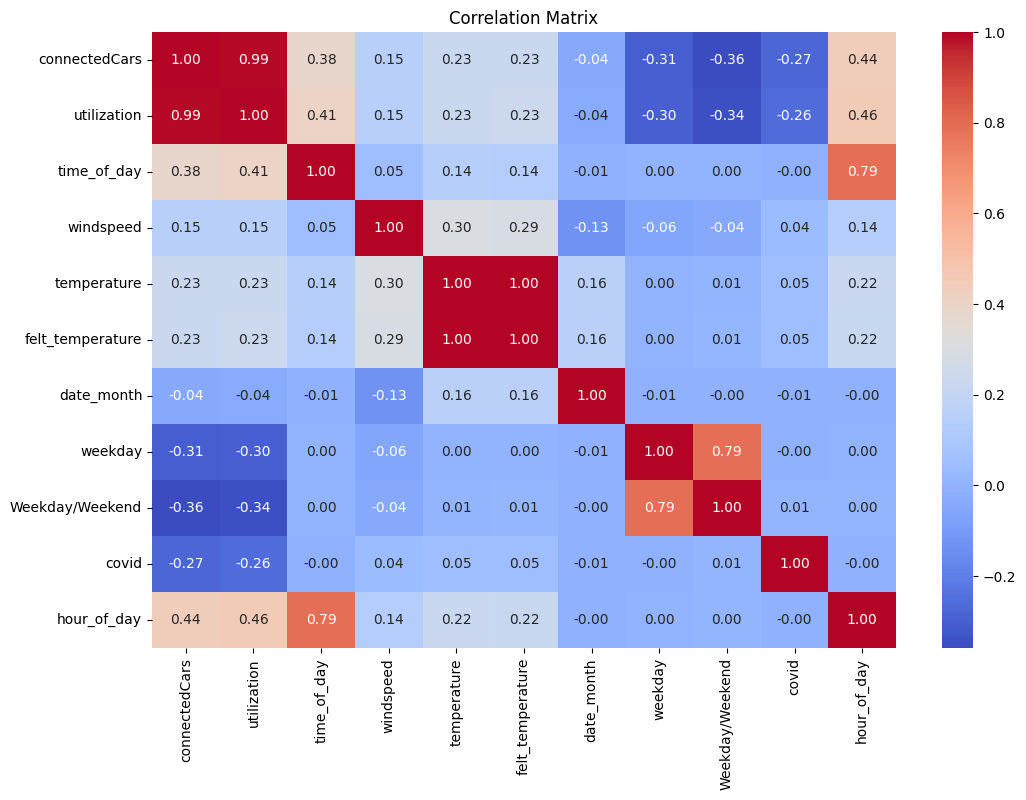

In [37]:
# compute correlation and display correlation for newly selected features
predictionDF_site1 = merged_data_site1[["connectedCars", "utilization","time_of_day","windspeed","temperature","felt_temperature","date_month","weekday","Weekday/Weekend","covid","hour_of_day"]]
correlation_matrix = predictionDF_site1.corr()
# plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Site 2:

In [38]:
# compute correlation matrix
correlation_matrix = merged_data_site2.corr()


# correlation with target feature
target_correlation = correlation_matrix['connectedCars'].sort_values(ascending=False)
print("Correlation with connectedCars:")
print(target_correlation)

Correlation with connectedCars:
connectedCars             1.000000
utilization               0.988808
felt_temperature          0.406886
temperature               0.403437
hour_of_day               0.310937
time_of_day               0.240828
windspeed                 0.233049
Season                    0.140222
temperature_difference    0.118462
cloud_cover               0.086688
fair                      0.055569
partly                    0.033636
haze                      0.031960
date_month                0.031942
thunder                   0.022552
t-storm                   0.016446
smoke                     0.001943
windy                    -0.001683
date_day                 -0.004771
heavy                    -0.007930
precipitation            -0.009303
light                    -0.025933
mostly                   -0.028087
rain                     -0.033953
fog                      -0.036501
cloudy                   -0.047277
pressure                 -0.100740
weekday                

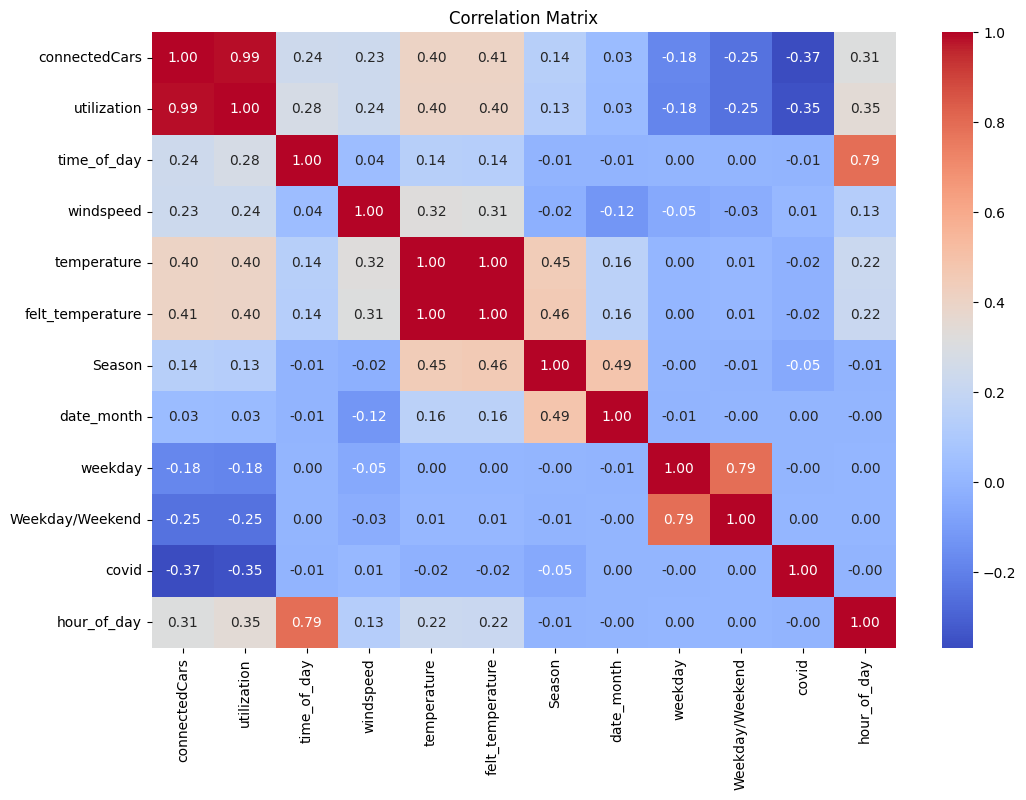

In [39]:
# compute correlation and display correlation for newly selected features
predictionDF_site2 = merged_data_site2[["connectedCars", "utilization","time_of_day","windspeed","temperature","felt_temperature","Season","date_month","weekday","Weekday/Weekend","covid","hour_of_day"]]
correlation_matrix = predictionDF_site2.corr()
# plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

---

### Prediction

### Random Forest 

Random Forest for Site 1, connectedCars

Before we run the regression models, we define the hyperparameter tuner. For the random forest regression we chose the gridsearch algorithm.

In [40]:
X_rf_s1_cc = predictionDF_site1[["windspeed","felt_temperature","date_month","weekday","Weekday/Weekend","hour_of_day","covid"]]
y_rf_s1_cc = predictionDF_site1['connectedCars']

# split data in 70% training and 30% testing data
X_rf_s1_train, X_rf_s1_test, y_rf_s1_train, y_rf_s1_test = train_test_split(X_rf_s1_cc, y_rf_s1_cc, test_size=0.3, random_state=42)

# Initialize the random forest regressor
rf_s1_cc = RandomForestRegressor(n_estimators=100, random_state=42)

# Define the hyperparameter grid
param_grid_rf_s1_cc = {
    'max_depth': range(1, 51),
    'ccp_alpha': loguniform(1e-5, 5),
}

# initialize hyperparameter search
random_search_rf_s1_cc = RandomizedSearchCV(
    estimator=rf_s1_cc,
    param_distributions=param_grid_rf_s1_cc,
    n_iter=50,
    cv=10,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# train model
random_search_rf_s1_cc.fit(X_rf_s1_train, y_rf_s1_train)

# get best parameters
best_params_rf_s1_cc = random_search_rf_s1_cc.best_params_
print(f"Best Parameters: {best_params_rf_s1_cc}")

# train model on best parameters
best_model_rf_s1_cc = RandomForestRegressor(
    n_estimators=100,
    max_depth=best_params_rf_s1_cc['max_depth'],
    ccp_alpha=best_params_rf_s1_cc['ccp_alpha'],
    random_state=42
)
best_model_rf_s1_cc.fit(X_rf_s1_train, y_rf_s1_train)

# evaluation metrics
rf_pred_s1_cc = best_model_rf_s1_cc.predict(X_rf_s1_test)

rf_mae_s1_cc = mean_absolute_error(y_rf_s1_test, rf_pred_s1_cc)
rf_rmse_s1_cc = np.sqrt(mean_squared_error(y_rf_s1_test, rf_pred_s1_cc))
r2_rf_s1_cc = r2_score(y_rf_s1_test, rf_pred_s1_cc)
print("MAE:", rf_mae_s1_cc)
print("RMSE:", rf_rmse_s1_cc)
print("R2:", r2_rf_s1_cc)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best Parameters: {'ccp_alpha': 1.0751532692987676e-05, 'max_depth': 11}
MAE: 2.9925370130764506
RMSE: 6.750453622493034
R2: 0.8715911310721344


Random Forest for Site 2, connectedCars

In [41]:
X_rf_s2_cc = predictionDF_site2[["windspeed","felt_temperature","date_month","weekday","Weekday/Weekend","hour_of_day","covid"]]
y_rf_s2_cc = predictionDF_site2['connectedCars']

# split data in 70% training and 30% testing data
X_rf_s2_cc_train, X_rf_s2_cc_test, y_rf_s2_cc_train, y_rf_s2_cc_test = train_test_split(X_rf_s2_cc, y_rf_s2_cc, test_size=0.3, random_state=42)

# initialize random forest regressor
rf_s2_cc = RandomForestRegressor(n_estimators=100, random_state=42)

# hyperparameter grid
param_grid_rf_s2_cc = {
    'max_depth': range(1, 51),
    'ccp_alpha': loguniform(1e-5, 5),
}

# initialize hyperparameter search
random_search_rf_s2_cc = RandomizedSearchCV(
    estimator=rf_s2_cc,
    param_distributions=param_grid_rf_s2_cc,
    n_iter=50,
    cv=10,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# train model
random_search_rf_s2_cc.fit(X_rf_s2_cc_train, y_rf_s2_cc_train)

# get best parameters
best_params_rf_s2_cc = random_search_rf_s2_cc.best_params_
print(f"Best Parameters: {best_params_rf_s2_cc}")

# train model with best parameters
best_model_rf_s2_cc = RandomForestRegressor(
    n_estimators=100,
    max_depth=best_params_rf_s2_cc['max_depth'],
    ccp_alpha=best_params_rf_s2_cc['ccp_alpha'],
    random_state=42
)
best_model_rf_s2_cc.fit(X_rf_s2_cc_train, y_rf_s2_cc_train)

# evaluation metrics
rf_pred_s2_cc = best_model_rf_s2_cc.predict(X_rf_s2_cc_test)
rf_mae_s2_cc = mean_absolute_error(y_rf_s2_cc_test, rf_pred_s2_cc)
rf_rmse_s2_cc = np.sqrt(mean_squared_error(y_rf_s2_cc_test, rf_pred_s2_cc))
r2_rf_s2_cc = r2_score(y_rf_s2_cc_test, rf_pred_s2_cc)
print("MAE:", rf_mae_s2_cc)
print("RMSE:", rf_rmse_s2_cc)
print("R2:", r2_rf_s2_cc)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best Parameters: {'ccp_alpha': 1.0751532692987676e-05, 'max_depth': 11}
MAE: 3.1907839295376252
RMSE: 5.045193062401657
R2: 0.8006182860103679


Random Forest for Site 1 Utilization

In [42]:
X_rf_s1_util = predictionDF_site1[["windspeed","felt_temperature","date_month","weekday","Weekday/Weekend","hour_of_day","covid"]]
y_rf_s1_util = predictionDF_site1['utilization']

# split data in 70% training and 30% testing data
X_rf_s1_util_train, X_rf_s1_util_test, y_rf_s1_util_train, y_rf_s1_util_test = train_test_split(X_rf_s1_util, y_rf_s1_util, test_size=0.3, random_state=42)

# initialize random forest regressor
rf_s1_util = RandomForestRegressor(n_estimators=100, random_state=42)

# hyperparameter grid
param_grid_rf_s1_util = {
    'max_depth': range(1, 51),
    'ccp_alpha': loguniform(1e-5, 5),
}

# initialize hyperparameter search
random_search_rf_s1_util = RandomizedSearchCV(
    estimator=rf_s1_util,
    param_distributions=param_grid_rf_s1_util,
    n_iter=50,
    cv=10,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# train model
random_search_rf_s1_util.fit(X_rf_s1_util_train, y_rf_s1_util_train)

# get best parameters
best_params = random_search_rf_s1_util.best_params_
print(f"Best Parameters: {best_params}")

# train model with best parameters
best_model_rf_s1_util = RandomForestRegressor(
    n_estimators=100,
    max_depth=best_params['max_depth'],
    ccp_alpha=best_params['ccp_alpha'],
    random_state=42
)
best_model_rf_s1_util.fit(X_rf_s1_util_train, y_rf_s1_util_train)

# evaluation metrics
rf_pred_s1_util = best_model_rf_s1_util.predict(X_rf_s1_util_test)
rf_mae_s1_util = mean_absolute_error(y_rf_s1_util_test, rf_pred_s1_util)
rf_rmse_s1_util = np.sqrt(mean_squared_error(y_rf_s1_util_test, rf_pred_s1_util))
r2_rf_s1_util = r2_score(y_rf_s1_util_test, rf_pred_s1_util)
print("MAE:", rf_mae_s1_util)
print("RMSE:", rf_rmse_s1_util)
print("R2:", r2_rf_s1_util)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best Parameters: {'ccp_alpha': 1.5702874159436416e-05, 'max_depth': 14}
MAE: 0.054206640290938024
RMSE: 0.12058295380532265
R2: 0.8701543332295748


Random Forest for Site 2 Utilization

In [43]:
X_rf_s2_util = predictionDF_site2[["windspeed","felt_temperature","date_month","weekday","Weekday/Weekend","hour_of_day","covid"]]
y_rf_s2_util = predictionDF_site2['utilization']

# split data in 70% training and 30% testing data
X_rf_s2_util_train, X_rf_s2_util_test, y_rf_s2_util_train, y_rf_s2_util_test = train_test_split(X_rf_s2_util, y_rf_s2_util, test_size=0.3, random_state=42)

# initialize random forest regressor
rf_s2_util = RandomForestRegressor(n_estimators=100, random_state=42)

# hyperparameter grid
param_grid_rf_s2_util = {
    'max_depth': range(1, 51),
    'ccp_alpha': loguniform(1e-5, 5),
}

# initialize hyperparameter search
random_search_rf_s2_util = RandomizedSearchCV(
    estimator=rf_s2_util,
    param_distributions=param_grid_rf_s2_util,
    n_iter=50,
    cv=10,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# train model
random_search_rf_s2_util.fit(X_rf_s2_util_train, y_rf_s2_util_train)

# get best parameters
best_params_rf_s2_util = random_search_rf_s2_util.best_params_
print(f"Best Parameters: {best_params_rf_s2_util}")

# train model with best parameters
best_model_rf_s2_util = RandomForestRegressor(
    n_estimators=100,
    max_depth=best_params['max_depth'],
    ccp_alpha=best_params['ccp_alpha'],
    random_state=42
)
best_model_rf_s2_util.fit(X_rf_s2_util_train, y_rf_s2_util_train)

# evaluation metrics
rf_pred_s2_util = best_model_rf_s2_util.predict(X_rf_s2_util_test)
rf_mae_s2_util = mean_absolute_error(y_rf_s2_util_test, rf_pred_s2_util)
rf_rmse_s2_util = np.sqrt(mean_squared_error(y_rf_s2_util_test, rf_pred_s2_util))
r2_rf_s2_util = r2_score(y_rf_s2_util_test, rf_pred_s2_util)
print("MAE:", rf_mae_s2_util)
print("RMSE:", rf_rmse_s2_util)
print("R2:", r2_rf_s2_util)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Best Parameters: {'ccp_alpha': 1.010271643196684e-05, 'max_depth': 21}
MAE: 0.05310559964035977
RMSE: 0.0831810731392845
R2: 0.8004292103408596


### Neural Network

Before we predict the connected cars per site, we construct our neural network and the hyperparameter tuner. For the hyperparameter search we use kera's Hyperband.

In [58]:
# construct the neural network
def construct_nn_model(hp):
    """
    Builds a neural network model with tunable hyperparameters using Keras Tuner.
       
    :param hp: kera's hyperparameter tuner
    """
    inputs = keras.Input(shape=(6,))

    # initial layer
    dense = layers.Dense(units=hp.Int('hidden_layer_1_units', min_value=32, max_value=256, step=32), activation='relu')
    
    x = dense(inputs)

    # hidden Layers
    for i in range(hp.Int('total_added_hidden_layers', 0, 10)):
        x = layers.Dense(units=hp.Int(f'hidden_layers_{i+2}_units', min_value=32, max_value=256, step=32), activation='relu')(x)

    # output Layer
    output = layers.Dense(1, activation='relu')(x)

    model_ann = keras.Model(inputs, output, name='neural_network')
    model_ann.compile(optimizer='Adam', loss='mean_squared_error')

    return model_ann

In [59]:
# initiaize hyperparameter tuner
hyperband_tuner_s1_cc = Hyperband(
    construct_nn_model,
    objective = 'val_loss',
    max_epochs = 20,
    factor = 3,
    executions_per_trial = 1,
    project_name = 'kerastuner_LOG',
    overwrite = True # deletes old LOG's
)

hyperband_tuner_s2_cc = Hyperband(
    construct_nn_model,
    objective = 'val_loss',
    max_epochs = 20,
    factor = 3,
    executions_per_trial = 1,
    project_name = 'kerastuner_LOG',
    overwrite = True # deletes old LOG's
)

hyperband_tuner_s1_util = Hyperband(
    construct_nn_model,
    objective = 'val_loss',
    max_epochs = 20,
    factor = 3,
    executions_per_trial = 1,
    project_name = 'kerastuner_LOG',
    overwrite = True # deletes old LOG's
)

hyperband_tuner_s2_util = Hyperband(
    construct_nn_model,
    objective = 'val_loss',
    max_epochs = 20,
    factor = 3,
    executions_per_trial = 1,
    project_name = 'kerastuner_LOG',
    overwrite = True # deletes old LOG's
)

In [60]:
# check the tuner search space exemplary for one, search space is identical for all tuners
hyperband_tuner_s1_cc.search_space_summary()

Search space summary
Default search space size: 2
hidden_layer_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
total_added_hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 10, 'step': 1, 'sampling': 'linear'}


To avoid overfloating this notebook with the training steps of the hyperparameter tuner we just initialized, we define a callback function that clears the respective output of the cell that runs the tuner:

In [61]:
class ClearTrainingOutput(keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

The following callback function stops the model fit earlier if the performance is not improved any further.

In [62]:
early_break = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=100,
    restore_best_weights=True
)

#### ConnectedCars Prediction for Site 1 with Neural Network

We split the data like this:
- 50% training data
- 20% validation data
- 30% test data

In comparison to the Random Forest Regressors we used k-fold cross validation which we do not use in here. Therefore we did not need to specifically split training data into training and validation sets. For the artificial neural networks we need to specify the validation sets specifically because we do not implement k-fold corss validation but the hyperparameter tuner Hyperband (Keras) which tunes the hyperparameters on the training set and evaluates them on the validation sets. 

In [63]:
# get data for connectedCars site 1 prediction
X_nn_s1 = predictionDF_site1.copy()
X_nn_s1 = X_nn_s1[["windspeed", "felt_temperature", "date_month", "Weekday/Weekend", "covid", "hour_of_day"]]
y_nn_s1 = predictionDF_site1[["connectedCars"]]

# split data in 70% training and 30% testing data
X_s1_train, X_s1_test, y_s1_train, y_s1_test = train_test_split(X_nn_s1, y_nn_s1, test_size=0.3, random_state=42)

# further split data into 50% training, 20% validation and 30% test data
X_s1_train, X_s1_val, y_s1_train, y_s1_val = train_test_split(X_s1_train, y_s1_train, test_size=(0.2/0.7),random_state = 42)

# normalize the feature data
scaler = StandardScaler()
X_s1_train = scaler.fit_transform(X_s1_train)
X_s1_val = scaler.fit_transform(X_s1_val)
X_s1_test = scaler.transform(X_s1_test)

# hyperparameter search
hyperband_tuner_s1_cc.search(X_s1_train, y_s1_train, validation_data=(X_s1_val,y_s1_val), callbacks = [ClearTrainingOutput()])

# get best hyperparameters
nn_model_s1_cc = hyperband_tuner_s1_cc.get_best_models(num_models=1)[0]

# display best hyperparameters
print("Model Hyperparameter Summary:")
best_params = hyperband_tuner_s1_cc.get_best_hyperparameters(num_trials=1)[0].values
print("\nBest Hyperparameters:")
for param, value in best_params.items():
    if not param.startswith('tuner/'):
        print(f"{param}: {value}")

# fit model
nn_model_s1_cc.fit(X_s1_train, y_s1_train, epochs=1000, validation_data=(X_s1_val,y_s1_val), callbacks=[early_break])

# predict on test data
nn_pred_s1 = nn_model_s1_cc.predict(X_s1_test)

# evaluation metrics
print("Model Performance:")
nn_mae_s1_cc = mean_absolute_error(y_s1_test,nn_pred_s1)
nn_rmse_s1_cc = np.sqrt(mean_squared_error(y_s1_test, nn_pred_s1))
nn_r2_s1_cc = r2_score(y_s1_test, nn_pred_s1)
print("MAE:", nn_mae_s1_cc)
print("RMSE:", nn_rmse_s1_cc)
print("R2:", nn_r2_s1_cc)

Trial 30 Complete [00h 00m 16s]
val_loss: 61.182838439941406

Best val_loss So Far: 59.7919807434082
Total elapsed time: 00h 04m 13s
Model Hyperparameter Summary:

Best Hyperparameters:
hidden_layer_1_units: 192
total_added_hidden_layers: 3
hidden_layers_2_units: 160
hidden_layers_3_units: 64
hidden_layers_4_units: 160
hidden_layers_5_units: 64
hidden_layers_6_units: 96
hidden_layers_7_units: 96
hidden_layers_8_units: 256
hidden_layers_9_units: 128
Epoch 1/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 64.6324 - val_loss: 60.5477
Epoch 2/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 63.5781 - val_loss: 59.4858
Epoch 3/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 61.6052 - val_loss: 61.1731
Epoch 4/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 64.2215 - val_loss: 62.9103
Epoch 5/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 63.2974 - val_loss: 59.5397
Epoch 6/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 61.9958 - val_loss: 60.7621
Epoch 7

#### Connected Cars Prediction for Site 2

In [64]:
# get data for connectedCars site 2 prediction
X_nn_s2 = predictionDF_site2.copy()
X_nn_s2 = X_nn_s2[["hour_of_day", "covid", "Weekday/Weekend", "Season", "temperature", "windspeed"]]
y_nn_s2 = predictionDF_site2[["connectedCars"]]

# split data in 70% training and 30% testing data
X_s2_train, X_s2_test, y_s2_train, y_s2_test = train_test_split(X_nn_s2, y_nn_s2, test_size=0.3, random_state=42)

# further split data into 50% training, 20% validation and 30% test data
X_s2_train, X_s2_val, y_s2_train, y_s2_val = train_test_split(X_s2_train, y_s2_train, test_size=(0.2/0.7),random_state = 42)

# normalize the feature data
scaler = StandardScaler()
X_s2_train = scaler.fit_transform(X_s2_train)
X_s2_val = scaler.fit_transform(X_s2_val)
X_s2_test = scaler.transform(X_s2_test)

# hyperparameter search
hyperband_tuner_s2_cc.search(X_s2_train, y_s2_train, validation_data=(X_s2_val,y_s2_val), callbacks = [ClearTrainingOutput()])

# get best hyperparameters
nn_model_s2_cc = hyperband_tuner_s2_cc.get_best_models(num_models=1)[0]

# display best hyperparameters
print("Model Hyperparameter Summary:")
best_params = hyperband_tuner_s2_cc.get_best_hyperparameters(num_trials=1)[0].values
print("\nBest Hyperparameters:")
for param, value in best_params.items():
    if not param.startswith('tuner/'):
        print(f"{param}: {value}")

# fit model
nn_model_s2_cc.fit(X_s2_train, y_s2_train, epochs=1000, validation_data=(X_s2_val,y_s2_val), callbacks=[early_break])

# predict on test data
nn_pred_s2_cc = nn_model_s2_cc.predict(X_s2_test)

# evaluation metrics
nn_mae_s2_cc = mean_absolute_error(y_s2_test, nn_pred_s2_cc)
nn_rmse_s2_cc = np.sqrt(mean_squared_error(y_s2_test, nn_pred_s2_cc))
nn_r2_s2_cc = r2_score(y_s2_test, nn_pred_s2_cc)
print("MAE:", nn_mae_s2_cc)
print("RMSE:", nn_rmse_s2_cc)
print("R2:", nn_r2_s2_cc)

Trial 30 Complete [00h 00m 18s]
val_loss: 35.24067687988281

Best val_loss So Far: 34.849796295166016
Total elapsed time: 00h 04m 49s
Model Hyperparameter Summary:

Best Hyperparameters:
hidden_layer_1_units: 224
total_added_hidden_layers: 2
hidden_layers_2_units: 192
hidden_layers_3_units: 256
hidden_layers_4_units: 64
hidden_layers_5_units: 32
hidden_layers_6_units: 96
hidden_layers_7_units: 224
hidden_layers_8_units: 160
hidden_layers_9_units: 192
hidden_layers_10_units: 192
hidden_layers_11_units: 32
Epoch 1/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 30.8887 - val_loss: 35.7795
Epoch 2/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31.0110 - val_loss: 36.5073
Epoch 3/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30.7903 - val_loss: 35.8889
Epoch 4/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30.5512 - val_loss: 37.0031
Epoch 5/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31.6974 - val_loss: 34.8133
Epoch 6/1000
372/372 ━━━━━━━━━━━━━━━━━━━

#### Utilization Prediction for Site 1

In [65]:
X_s1_nn_util = predictionDF_site1.copy()
X_s1_nn_util = X_s1_nn_util[['windspeed', 'felt_temperature', 'date_month', 'Weekday/Weekend', 'covid', 'hour_of_day']]
y_s1_nn_util = predictionDF_site1[["utilization"]]

# split data in 70% training and 30% testing data
X_s1_util_train, X_s1_util_test, y_s1_util_train, y_s1_util_test = train_test_split(X_s1_nn_util, y_s1_nn_util, test_size=0.3, random_state=42)

# further split data into 50% training, 20% validation and 30% test data
X_s1_util_train, X_s1_util_val, y_s1_util_train, y_s1_util_val = train_test_split(X_s1_util_train, y_s1_util_train, test_size=(0.2/0.7),random_state = 42)

# normalize the feature data
scaler = StandardScaler()
X_s1_util_train = scaler.fit_transform(X_s1_util_train)
X_s1_util_val = scaler.fit_transform(X_s1_util_val)
X_s1_util_test = scaler.transform(X_s1_util_test)

# hyperparameter search
hyperband_tuner_s1_util.search(X_s1_util_train, y_s1_util_train, validation_data=(X_s1_util_val,y_s1_util_val), callbacks = [ClearTrainingOutput()])

# get best hyperparameters
nn_model_s1_util = hyperband_tuner_s1_util.get_best_models(num_models=1)[0]

# display best hyperparameters
print("Model Hyperparameter Summary:")
best_params = hyperband_tuner_s1_util.get_best_hyperparameters(num_trials=1)[0].values
print("\nBest Hyperparameters:")
for param, value in best_params.items():
    if not param.startswith('tuner/'):
        print(f"{param}: {value}")

# fit model
nn_model_s1_util.fit(X_s1_util_train, y_s1_util_train, epochs=1000, validation_data=(X_s1_util_val,y_s1_util_val), callbacks=[early_break])

# predict on test data
nn_pred_site1_util = nn_model_s1_util.predict(X_s1_util_test)

# evaluation metrics
nn_mae_s1_util = mean_absolute_error(y_s1_util_test,nn_pred_site1_util)
nn_rmse_s1_util = np.sqrt(mean_squared_error(y_s1_util_test,nn_pred_site1_util))
nn_r2_s1_util = r2_score(y_s1_util_test, nn_pred_site1_util)

print("MAE:", nn_mae_s1_util)
print("RMSE:", nn_rmse_s1_util)
print("R2:", nn_r2_s1_util)

Trial 30 Complete [00h 00m 16s]
val_loss: 0.1546415090560913

Best val_loss So Far: 0.01895986497402191
Total elapsed time: 00h 04m 57s
Model Hyperparameter Summary:

Best Hyperparameters:
hidden_layer_1_units: 32
total_added_hidden_layers: 5
hidden_layers_2_units: 224
hidden_layers_3_units: 256
hidden_layers_4_units: 32
hidden_layers_5_units: 256
hidden_layers_6_units: 64
hidden_layers_7_units: 128
hidden_layers_8_units: 32
hidden_layers_9_units: 96
hidden_layers_10_units: 192
Epoch 1/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0187 - val_loss: 0.0205
Epoch 2/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0194 - val_loss: 0.0190
Epoch 3/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0184 - val_loss: 0.0198
Epoch 4/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0175 - val_loss: 0.0213
Epoch 5/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0202 - val_loss: 0.0219
Epoch 6/1000
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0193 - val_lo

####  Utilization Prediction for Site 2

In [67]:
X_s2_nn_util = predictionDF_site2.copy()
X_s2_nn_util = X_s2_nn_util[["hour_of_day", "covid", "Weekday/Weekend", "Season", "temperature", "windspeed"]]
y_s2_nn_util = predictionDF_site2[["utilization"]]

# split data in 70% training and 30% testing data
X_s2_util_train, X_s2_util_test, y_s2_util_train, y_s2_util_test = train_test_split(X_s2_nn_util, y_s2_nn_util, test_size=0.3, random_state=42)

# further split data into 50% training, 20% validation and 30% test data
X_s2_util_train, X_s2_util_val, y_s2_util_train, y_s2_util_val = train_test_split(X_s2_util_train, y_s2_util_train, test_size=(0.2/0.7),random_state = 42)

# normalize the feature data
scaler = StandardScaler()
X_s2_util_train = scaler.fit_transform(X_s2_util_train)
X_s2_util_val = scaler.fit_transform(X_s2_util_val)
X_s2_util_test = scaler.transform(X_s2_util_test)

# hyperparameter search
hyperband_tuner_s2_util.search(X_s2_util_train, y_s2_util_train, validation_data=(X_s2_util_val,y_s2_util_val), callbacks = [ClearTrainingOutput()])

# get best hyperparameters
nn_model_s2_util = hyperband_tuner_s2_util.get_best_models(num_models=1)[0]

# display best hyperparameters
print("Model Hyperparameter Summary:")
best_params = hyperband_tuner_s2_util.get_best_hyperparameters(num_trials=1)[0].values
print("\nBest Hyperparameters:")
for param, value in best_params.items():
    if not param.startswith('tuner/'):
        print(f"{param}: {value}")

# fit model
nn_model_s2_util.fit(X_s2_util_train, y_s2_util_train, epochs=1000, validation_data=(X_s2_util_val,y_s2_util_val), callbacks=[early_break])

# predict on test data
nn_pred_site2_util = nn_model_s2_util.predict(X_s2_util_test)

# evaluation metrics
nn_mae_s2_util = mean_absolute_error(y_s2_util_test, nn_pred_site2_util)
nn_rmse_s2_util = np.sqrt(mean_squared_error(y_s2_util_test, nn_pred_site2_util))
nn_r2_s2_util = r2_score(y_s2_util_test, nn_pred_site2_util)

print("MAE:", nn_mae_s2_util)
print("RMSE:", nn_rmse_s2_util)
print("R2:", nn_r2_s2_util)

Trial 30 Complete [00h 00m 17s]
val_loss: 0.057028453797101974

Best val_loss So Far: 0.009048178791999817
Total elapsed time: 00h 05m 24s
Model Hyperparameter Summary:

Best Hyperparameters:
hidden_layer_1_units: 224
total_added_hidden_layers: 5
hidden_layers_2_units: 96
hidden_layers_3_units: 96
hidden_layers_4_units: 96
hidden_layers_5_units: 64
hidden_layers_6_units: 224
hidden_layers_7_units: 32
hidden_layers_8_units: 160
hidden_layers_9_units: 128
hidden_layers_10_units: 256
Epoch 1/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0084 - val_loss: 0.0096
Epoch 2/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0081 - val_loss: 0.0092
Epoch 3/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0083 - val_loss: 0.0094
Epoch 4/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0080 - val_loss: 0.0093
Epoch 5/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0085 - val_loss: 0.0092
Epoch 6/1000
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0078 - val